In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from utils import load_data, process_graph_data
from utils import package_mxl, adj_rw_norm
from utils import sparse_mx_to_torch_sparse_tensor
from utils import ResultRecorder

from model import GCN, GCNBias, SGC, ResGCN, GCNII, APPNP
from layers import GraphConv
from load_semigcn_data import load_data_gcn
from data_loader import DataLoader

from sklearn.metrics import f1_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.sparse.csgraph import connected_components

from tqdm import trange
import numpy as np
import copy 
import time
import pickle
import os

import sys; sys.argv=['']; del sys
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import argparse
"""
Dataset arguments
"""
parser = argparse.ArgumentParser(
    description='Training GCN on Large-scale Graph Datasets')
parser.add_argument('--dataset', type=str, default='citeseer',
                    help='Dataset name: pubmed/flickr/reddit/ppi-large')
parser.add_argument('--method', type=str, default='SGC/GCN/GCNBias/ResGCN/GCNII/APPNP',
                    help='Algorithms: seperate using slash')
parser.add_argument('--nhid', type=int, default=64,
                    help='Hidden state dimension')
parser.add_argument('--epoch_num', type=int, default=500,
                    help='Number of Epoch')
parser.add_argument('--batch_size', type=int, default=99999,
                    help='size of output node in a batch')
parser.add_argument('--n_layers', type=int, default=10,
                    help='Number of GCN layers')
parser.add_argument('--dropout', type=float, default=0,
                    help='Dropout rate')
parser.add_argument('--cuda', type=int, default=0,
                    help='Avaiable GPU ID')
args = parser.parse_args()
print(args)

method = args.method.split('/')

"""
Prepare devices
"""
if args.cuda != -1:
    device = torch.device("cuda:" + str(args.cuda))
else:
    device = torch.device("cpu")
    
if args.dataset not in ['cora', 'citeseer', 'pubmed']:
    temp_data = load_data(args.dataset) 
else:
    temp_data = load_data_gcn(args.dataset)

adj_full, adj_train, feat_data, labels, role = process_graph_data(*temp_data)

train_nodes = np.array(role['tr'])
valid_nodes = np.array(role['va'])
test_nodes = np.array(role['te'])

data_loader = DataLoader(adj_full, train_nodes, valid_nodes, test_nodes, device)

Namespace(batch_size=99999, cuda=0, dataset='citeseer', dropout=0, epoch_num=500, method='SGC/GCN/GCNBias/ResGCN/GCNII/APPNP', n_layers=10, nhid=64)


In [2]:
def compute_hidden_dist(model, feat_data_th, data_loader):
    unique_labels = np.arange(num_classes)
    class_to_indices = dict()
    for i in unique_labels:
        class_to_indices[i] = np.where(np.argmax(labels, axis=1)==i)[0]

    inner_class_dist_list = []
    cross_class_dist_list = []
    for hiddens in model.fetch_hiddens(feat_data_th, data_loader.lap_tensor):
        hiddens_norm = np.linalg.norm(hiddens)

        inner_class_dist = []
        for i in unique_labels:
            indices = class_to_indices[i]
            dists = pairwise_distances(hiddens[indices])
            inner_class_dist.append(dists.mean())
        inner_class_dist_list += [np.mean(inner_class_dist)/hiddens_norm]

        cross_class_dist = []
        all_nodes_indices = np.arange(len(labels))
        for i in unique_labels:
            indices = class_to_indices[i]
            other_indices = np.setdiff1d(all_nodes_indices, indices)
            dists = pairwise_distances(hiddens[indices], hiddens[other_indices])
            cross_class_dist.append(dists.mean())
        cross_class_dist_list += [np.mean(cross_class_dist)/hiddens_norm]
    return inner_class_dist_list, cross_class_dist_list

In [3]:
"""
Setup datasets and models for training (multi-class use sigmoid+binary_cross_entropy, use softmax+nll_loss otherwise)
"""

if args.dataset in ['flickr', 'reddit', 'cora', 'citeseer', 'pubmed']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.LongTensor(labels.argmax(1))
    num_classes = labels_th.max().item()+1
    criterion = nn.CrossEntropyLoss()
    multi_class=False
elif args.dataset in ['ppi', 'ppi-large', 'amazon', 'yelp']:
    feat_data_th = torch.FloatTensor(feat_data)
    labels_th = torch.FloatTensor(labels)
    num_classes = labels_th.shape[1]
    criterion = nn.BCEWithLogitsLoss()
    multi_class=True

feat_data_th = feat_data_th.to(device)
labels_th = labels_th.to(device)

def sgd_step(net, optimizer, feat_data, labels, train_data, device):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    net.train()
    epoch_loss = []
    epoch_acc = []
    
    # Run over the train_loader
    mini_batches, adj = train_data
    for mini_batch in mini_batches:

        # compute current stochastic gradient
        optimizer.zero_grad()
        output = net(feat_data, adj)
        
        loss = net.criterion(output[mini_batch], labels[mini_batch])
        loss.backward()
        
        optimizer.step()
        epoch_loss.append(loss.item())
        
        if multi_class:
            output[output > 0.5] = 1
            output[output <= 0.5] = 0
        else:
            output = output.argmax(dim=1)

        acc = f1_score(output[mini_batch].detach().cpu(), 
                       labels[mini_batch].detach().cpu(), average="micro")
        epoch_acc.append(acc)

    return epoch_loss, epoch_acc

@torch.no_grad()
def inference(eval_model, feat_data, labels, test_data, device):
    eval_model = eval_model.to(device)
    mini_batch, adj = test_data    
    output = eval_model(feat_data, adj)
    loss = eval_model.criterion(output[mini_batch], labels[mini_batch]).item()
    
    if multi_class:
        output[output > 0.5] = 1
        output[output <= 0.5] = 0
    else:
        output = output.argmax(dim=1)
        
    acc = f1_score(output[mini_batch].detach().cpu(), 
                   labels[mini_batch].detach().cpu(), average="micro")
    return loss, acc

"""
Train without sampling
"""

def train_model(model, data_loader, note):
    train_model = copy.deepcopy(model).to(device)
    
    results = ResultRecorder(note=note)

    optimizer = optim.Adam(train_model.parameters())

    tbar = trange(args.epoch_num, desc='Training Epochs')
    for epoch in tbar:
        # fetch train data 
        
        sample_time_st = time.perf_counter()
        train_data = data_loader.get_mini_batches(batch_size=args.batch_size)
        sample_time = time.perf_counter() - sample_time_st
        
        compute_time_st = time.perf_counter()
        train_loss, train_acc = sgd_step(train_model, optimizer, feat_data_th, labels_th, train_data, device)
        compute_time = time.perf_counter() - compute_time_st
        
        epoch_train_loss = np.mean(train_loss)
        epoch_train_acc = np.mean(train_acc)

        valid_data = data_loader.get_valid_batch()
        epoch_valid_loss, epoch_valid_acc = inference(train_model, feat_data_th, labels_th, valid_data, device)
        tbar.set_postfix(loss=epoch_train_loss,
                         val_loss=epoch_valid_loss,
                         val_score=epoch_valid_acc)

        results.update(epoch_train_loss, 
                       epoch_train_acc,
                       epoch_valid_loss, 
                       epoch_valid_acc, 
                       train_model, sample_time=sample_time, compute_time=compute_time)


    test_data = data_loader.get_test_batch()
    epoch_test_loss, epoch_test_acc = inference(results.best_model, feat_data_th, labels_th, test_data, device)
    results.test_loss = epoch_test_loss
    results.test_acc = epoch_test_acc
    print('Test_loss: %.4f | test_acc: %.4f' % (epoch_test_loss, epoch_test_acc))
    
    print('Average sampling time %.5fs, average computing time %.5fs'%
          (np.mean(results.sample_time), np.mean(results.compute_time)))
    
    return results

In [4]:
def get_pairwise_dist(results_list):
    inner_dist = []
    cross_dist = []

    for result in results_list:
        inner_dist.append(result.inner_dist_after)
        cross_dist.append(result.cross_dist_after)
    return inner_dist, cross_dist

In [5]:
class SGC(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        super(SGC, self).__init__()
        from layers import SGCLayer
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(SGCLayer())
        # self.linear_in = nn.Linear(n_feat, n_hid)
        # self.linear_out = nn.Linear(n_hid, n_classes)
        self.linear_out = nn.Linear(n_feat, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        # x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
        x = self.linear_out(x)
        return x
    
    @torch.no_grad()
    def fetch_hiddens(self, x, adj):
        hiddens = []
        hiddens.append(x.clone().cpu().numpy())
        # x = self.linear_in(x)
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            hiddens.append(x.clone().cpu().numpy())
        x = self.linear_out(x)
        return hiddens
    
results_list = []
for repeat in range(10):
    model = SGC(n_feat=feat_data.shape[1], 
                n_hid=args.nhid, 
                n_classes=num_classes, 
                n_layers=args.n_layers, 
                dropout=args.dropout, 
                criterion=criterion)
    model_untrain = copy.deepcopy(model)
    results = train_model(model, data_loader, note="SGC (L=%d)"%args.n_layers)
    results.inner_dist, results.cross_dist = compute_hidden_dist(model_untrain.to(device), feat_data_th, data_loader)
    results.inner_dist_after, results.cross_dist_after = compute_hidden_dist(results.best_model.to(device), feat_data_th, data_loader)
    results_list.append(results)

Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.20it/s, loss=0.417, val_loss=0.923, val_score=0.716]


Test_loss: 0.9315 | test_acc: 0.7590
Average sampling time 0.00007s, average computing time 0.04509s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s, loss=0.417, val_loss=0.923, val_score=0.72] 


Test_loss: 0.9382 | test_acc: 0.7560
Average sampling time 0.00007s, average computing time 0.04449s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s, loss=0.417, val_loss=0.924, val_score=0.718]


Test_loss: 0.9661 | test_acc: 0.7560
Average sampling time 0.00007s, average computing time 0.04450s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s, loss=0.416, val_loss=0.923, val_score=0.722]


Test_loss: 0.9391 | test_acc: 0.7560
Average sampling time 0.00007s, average computing time 0.04450s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.27it/s, loss=0.417, val_loss=0.923, val_score=0.72] 


Test_loss: 0.9063 | test_acc: 0.7570
Average sampling time 0.00007s, average computing time 0.04453s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.26it/s, loss=0.416, val_loss=0.923, val_score=0.718]


Test_loss: 0.9053 | test_acc: 0.7560
Average sampling time 0.00007s, average computing time 0.04455s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.26it/s, loss=0.417, val_loss=0.923, val_score=0.72] 


Test_loss: 0.9408 | test_acc: 0.7590
Average sampling time 0.00007s, average computing time 0.04454s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.26it/s, loss=0.417, val_loss=0.922, val_score=0.72] 


Test_loss: 0.9119 | test_acc: 0.7570
Average sampling time 0.00007s, average computing time 0.04454s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.23it/s, loss=0.416, val_loss=0.922, val_score=0.722]


Test_loss: 0.9402 | test_acc: 0.7560
Average sampling time 0.00007s, average computing time 0.04467s


Training Epochs: 100%|██████████| 500/500 [00:44<00:00, 11.26it/s, loss=0.417, val_loss=0.922, val_score=0.72] 


Test_loss: 1.0180 | test_acc: 0.7530
Average sampling time 0.00007s, average computing time 0.04457s


In [6]:
print(len(results_list))
inner_dist, cross_dist = get_pairwise_dist(results_list)
ALGORITHM='SGC'
DATASET='Citeseer'
fig, axs = plt.subplots()

data_mat = np.array(inner_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

data_mat = np.array(cross_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

data_mat = np.array(cross_dist) - np.array(inner_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('Intra- and inter-class distance / Num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Intra- and inter-class distance')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
plt.close()

10


In [7]:
y_stds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [8]:
class APPNP(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import APPNPLayer
        super(APPNP, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        for _ in range(n_layers):
            self.gcs.append(APPNPLayer())
        # self.linear_in = nn.Linear(n_feat, n_hid)
        # self.linear_out = nn.Linear(n_hid, n_classes)
        self.linear_out = nn.Linear(n_feat, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        # x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj, x_0, alpha=0.8)
        x = self.linear_out(x)
        return x
    
    @torch.no_grad()
    def fetch_hiddens(self, x, adj):
        hiddens = []
        hiddens.append(x.clone().cpu().numpy())
        # x = self.linear_in(x)
        x_0 = x.clone()
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj, x_0, alpha=0.8)
            hiddens.append(x.clone().cpu().numpy())
        return hiddens
    
results_list = []
for repeat in range(10):
    model = APPNP(n_feat=feat_data.shape[1], 
                n_hid=args.nhid, 
                n_classes=num_classes, 
                n_layers=args.n_layers, 
                dropout=args.dropout, 
                criterion=criterion)
    model_untrain = copy.deepcopy(model)
    results = train_model(model, data_loader, note="APPNP (L=%d)"%args.n_layers)
    results.inner_dist, results.cross_dist = compute_hidden_dist(model_untrain.to(device), feat_data_th, data_loader)
    results.inner_dist_after, results.cross_dist_after = compute_hidden_dist(results.best_model.to(device), feat_data_th, data_loader)
    results_list.append(results)

Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s, loss=0.216, val_loss=0.905, val_score=0.726]


Test_loss: 0.7700 | test_acc: 0.7830
Average sampling time 0.00006s, average computing time 0.05829s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.57it/s, loss=0.216, val_loss=0.906, val_score=0.726]


Test_loss: 0.8871 | test_acc: 0.7880
Average sampling time 0.00006s, average computing time 0.05831s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s, loss=0.217, val_loss=0.905, val_score=0.724]


Test_loss: 0.8996 | test_acc: 0.7940
Average sampling time 0.00006s, average computing time 0.05831s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.57it/s, loss=0.217, val_loss=0.904, val_score=0.722]


Test_loss: 0.8930 | test_acc: 0.7890
Average sampling time 0.00006s, average computing time 0.05833s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.57it/s, loss=0.216, val_loss=0.906, val_score=0.726]


Test_loss: 0.9014 | test_acc: 0.7910
Average sampling time 0.00006s, average computing time 0.05832s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s, loss=0.216, val_loss=0.907, val_score=0.726]


Test_loss: 0.9068 | test_acc: 0.7890
Average sampling time 0.00006s, average computing time 0.05830s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.57it/s, loss=0.216, val_loss=0.906, val_score=0.724]


Test_loss: 0.7865 | test_acc: 0.7840
Average sampling time 0.00006s, average computing time 0.05832s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s, loss=0.217, val_loss=0.906, val_score=0.724]


Test_loss: 0.9024 | test_acc: 0.7890
Average sampling time 0.00006s, average computing time 0.05831s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.57it/s, loss=0.216, val_loss=0.905, val_score=0.724]


Test_loss: 0.8737 | test_acc: 0.7900
Average sampling time 0.00006s, average computing time 0.05832s


Training Epochs: 100%|██████████| 500/500 [00:58<00:00,  8.58it/s, loss=0.217, val_loss=0.904, val_score=0.726]


Test_loss: 0.9093 | test_acc: 0.7920
Average sampling time 0.00006s, average computing time 0.05830s


In [9]:
print(len(results_list))
inner_dist, cross_dist = get_pairwise_dist(results_list)
ALGORITHM='APPNP'
DATASET='Citeseer'
fig, axs = plt.subplots()

data_mat = np.array(inner_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

data_mat = np.array(cross_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

data_mat = np.array(cross_dist) - np.array(inner_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('Intra- and inter-class distance / Num of layers')
axs.set_xlabel('Num of layers')
axs.set_ylabel('Intra- and inter-class distance')
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()
plt.legend()

plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
plt.close()

10


In [10]:
class GCN(nn.Module):
    def __init__(self, n_feat, n_hid, n_classes, n_layers, dropout, criterion):
        from layers import GraphConv
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.n_hid = n_hid
        
        self.gcs = nn.ModuleList()
        self.gcs.append(GraphConv(n_feat,  n_hid))
        for _ in range(n_layers-1):
            self.gcs.append(GraphConv(n_hid,  n_hid))
        self.linear = nn.Linear(n_hid, n_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.criterion = criterion

    def forward(self, x, adj):
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.linear(x)
        return x
    
    @torch.no_grad()
    def fetch_hiddens(self, x, adj):
        hiddens = []
        hiddens.append(x.clone().cpu().numpy())
        for ell in range(len(self.gcs)):
            x = self.gcs[ell](x, adj)
            hiddens.append(x.clone().cpu().numpy())
            x = self.relu(x)
            x = self.dropout(x)
        return hiddens
    
results_list = []
for repeat in range(10):
    model = GCN(n_feat=feat_data.shape[1], 
                n_hid=args.nhid, 
                n_classes=num_classes, 
                n_layers=args.n_layers, 
                dropout=args.dropout, 
                criterion=criterion)
    model_untrain = copy.deepcopy(model)
    results = train_model(model, data_loader, note="GCN (L=%d)"%args.n_layers)
    results.inner_dist, results.cross_dist = compute_hidden_dist(model_untrain.to(device), feat_data_th, data_loader)
    results.inner_dist_after, results.cross_dist_after = compute_hidden_dist(results.best_model.to(device), feat_data_th, data_loader)
    results_list.append(results)

Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.05it/s, loss=0.279, val_loss=5.13, val_score=0.642]


Test_loss: 2.3142 | test_acc: 0.7080
Average sampling time 0.00007s, average computing time 0.01512s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.30it/s, loss=0.257, val_loss=5.46, val_score=0.652]


Test_loss: 3.3380 | test_acc: 0.7100
Average sampling time 0.00006s, average computing time 0.01509s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.25it/s, loss=0.276, val_loss=5.03, val_score=0.666]


Test_loss: 2.2876 | test_acc: 0.7170
Average sampling time 0.00006s, average computing time 0.01508s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.19it/s, loss=0.322, val_loss=4.07, val_score=0.654]


Test_loss: 2.4766 | test_acc: 0.7050
Average sampling time 0.00006s, average computing time 0.01511s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.21it/s, loss=0.227, val_loss=4.01, val_score=0.668]


Test_loss: 1.5887 | test_acc: 0.7230
Average sampling time 0.00006s, average computing time 0.01508s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.39it/s, loss=0.221, val_loss=3.65, val_score=0.662]


Test_loss: 0.9805 | test_acc: 0.7060
Average sampling time 0.00006s, average computing time 0.01510s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.32it/s, loss=0.265, val_loss=4.51, val_score=0.676]


Test_loss: 1.3940 | test_acc: 0.7180
Average sampling time 0.00007s, average computing time 0.01511s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.25it/s, loss=0.31, val_loss=3.2, val_score=0.668]  


Test_loss: 1.9437 | test_acc: 0.6900
Average sampling time 0.00006s, average computing time 0.01506s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.29it/s, loss=0.267, val_loss=6.05, val_score=0.642]


Test_loss: 2.8404 | test_acc: 0.7030
Average sampling time 0.00006s, average computing time 0.01509s


Training Epochs: 100%|██████████| 500/500 [00:12<00:00, 39.33it/s, loss=0.273, val_loss=5.17, val_score=0.628]


Test_loss: 3.3758 | test_acc: 0.6900
Average sampling time 0.00006s, average computing time 0.01507s


10


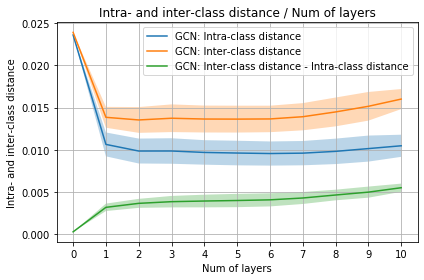

In [12]:
# print(len(results_list))
# inner_dist, cross_dist = get_pairwise_dist(results_list)
# ALGORITHM='GCN'
# DATASET='Cora'
# fig, axs = plt.subplots()

# data_mat = np.array(inner_dist)
# y_vals = np.mean(data_mat, axis=0)
# y_stds = np.std(data_mat, axis=0)
# x_vals = np.arange(len(y_vals))
# axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
# axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# data_mat = np.array(cross_dist)
# y_vals = np.mean(data_mat, axis=0)
# y_stds = np.std(data_mat, axis=0)
# x_vals = np.arange(len(y_vals))
# axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
# axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# data_mat = np.array(cross_dist) - np.array(inner_dist)
# y_vals = np.mean(data_mat, axis=0)
# y_stds = np.std(data_mat, axis=0)
# x_vals = np.arange(len(y_vals))
# axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra-class distance'%ALGORITHM)
# axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

# plt.title('Intra- and inter-class distance / Num of layers')
# axs.set_xlabel('Num of layers')
# axs.set_ylabel('Intra- and inter-class distance')
# axs.grid(True)
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
# fig.tight_layout()
# plt.legend()

# # plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
# # plt.close()

10


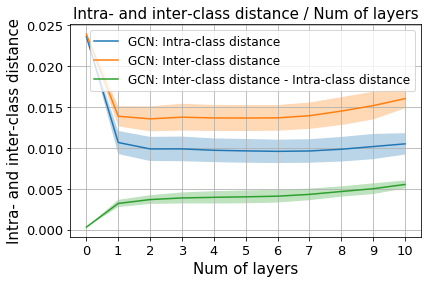

In [16]:
print(len(results_list))
inner_dist, cross_dist = get_pairwise_dist(results_list)
ALGORITHM='GCN'
DATASET='Cora'
fig, axs = plt.subplots()

data_mat = np.array(inner_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Intra-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

data_mat = np.array(cross_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Inter-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

data_mat = np.array(cross_dist) - np.array(inner_dist)
y_vals = np.mean(data_mat, axis=0)
y_stds = np.std(data_mat, axis=0)
x_vals = np.arange(len(y_vals))
axs.plot(x_vals, y_vals, label='%s: Inter-class distance - Intra-class distance'%ALGORITHM)
axs.fill_between(x_vals, y_vals-y_stds, y_vals+y_stds ,alpha=0.3)

plt.title('Intra- and inter-class distance / Num of layers', fontsize=15)
axs.set_xlabel('Num of layers', fontsize=15)
axs.set_ylabel('Intra- and inter-class distance', fontsize=15)
axs.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
fig.tight_layout()

fs = 14
for tick in axs.xaxis.get_major_ticks():
    tick.label.set_fontsize(fs-1)

for tick in axs.yaxis.get_major_ticks():
    tick.label.set_fontsize(fs-1)
    
plt.legend(fontsize=12)

# plt.savefig('pariwise_%s_%s.pdf'%(DATASET, ALGORITHM))
# plt.close()